In [304]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from far_heaa.grids_and_combinations.combination_generation import MultinaryCombinations
from far_heaa.io.json_handler import JSONHandler
from far_heaa.high_throughput.realignment_maths import get_realignment_energy
import seaborn as sns

from far_heaa.math_operations.thermo_calculations import ThermoMaths

In [305]:
system = 4
element_list = ['Cr', 'V', 'W', 'Ti', 'Ta', 'Fe', 'Mo', 'Nb', 'Zr', 'Hf']
file = JSONHandler.load_json(folder_path='/Users/pravanomprakash/Library/CloudStorage/Box-Box/HEA_alloys/done_data', file_name=f'{system}_add_ele_paths_total_10_BCC_wo_im')

data = JSONHandler.load_json(folder_path='../database', file_name='bokas_omegas_processed')
mol_grid_size = 5
x = np.linspace(0, 1, mol_grid_size)

results_dict = {}
miscible_keys = []
never_miscible_keys = []
possible_miscible_keys = []
tm = ThermoMaths()
throw_away = []
error_count = 0

h_alloy_list = []
h_comp_list = []
h_r_list = []
temperature_list = []
im_formation_list = []
reduction = []
add_ele_list = []
with open('../database/intermetallic_database.pickle', 'rb') as handle:
	im_list = pickle.load(handle)
counter = {}
base_alloy_list = []
for key, value in file.items():
	for add_ele, temp_list in value.items():
		composition = key.split('-')
		if add_ele in composition:
			composition.remove(add_ele)
		temp_array = np.array(temp_list)
		temp_array[temp_array == -1000.0] = np.nan
		
		if np.isnan(temp_array[0]) or np.isnan(temp_array[-1]):
			continue
		if temp_array[0] < 200 or np.isnan(temp_array[0]):
		# if True:
			# indices = temp_array[-1] >= 200
			indices = list(np.where(temp_array >= 200)[0])
			if len(indices) != 0:
			# if True:
				speed = min(indices)
				counter.update({speed: counter.get(speed, 0) + 1})
				h_alloy = 0
				im_formation = []

				for j in composition:
					h_alloy += data['-'.join(sorted([j, add_ele]))]['BCC']
					im_formation += [k.energy / k.composition.num_atoms for k in im_list['-'.join(sorted([j, add_ele]))] if
									 '-'.join(sorted([j, add_ele])) in im_list]

				h_alloy_list.append(h_alloy)
				h_r = get_realignment_energy(element_list=composition + [add_ele], lattice='BCC', data=data)
				h_r_list.append(h_r)
				h_comp = 0
				for j in list(MultinaryCombinations.create_multinary(composition, no_comb=[2]).values())[0]:
					h_comp += data[j]['BCC']
					# im_formation += [k.energy / k.composition.num_atoms for k in im_list[j] if j in im_list]
				if '-'.join(sorted(composition + [add_ele])) in im_list:
					im_formation += [k.energy / k.composition.num_atoms for k in
									 im_list['-'.join(sorted(composition + [add_ele]))]]

				if not im_formation:
					im_formation = 0
				h_comp_list.append(h_comp)
				im_formation_list.append(min(im_formation))

				alloy_temp = tm.avg_T_melt(composition=composition, mol_ratio=[1 / system] * system)
				element_temp = tm.avg_T_melt(composition=composition + [add_ele], mol_ratio=[1 / (system + 1)] * (system + 1))
				temperature_list.append(float(element_temp - alloy_temp))
				if np.isnan(temp_array[-1]):
					reduction.append(-2000 - temp_array[0])
				elif np.isnan(temp_array[0]):
					reduction.append(temp_array[-1] + 3500)
				else:
					reduction.append(temp_array[-1] - temp_array[0])

				add_ele_list.append(add_ele)
				base_alloy_list.append(key)

In [306]:
h_comp_list = np.array(h_comp_list)
h_alloy_list = np.array(h_alloy_list)
reduction = np.array(reduction)
im_formation_list = np.array(im_formation_list)
temperature_list = np.array(temperature_list)

In [307]:
counter


{1: 66, 3: 2, 2: 1, 4: 2}

In [308]:
unique, counts = np.unique(np.array(base_alloy_list), return_counts=True)

In [309]:
print(base_alloy_list)

['Cr-Fe-Hf-Nb-Ti', 'Cr-Fe-Hf-Ta-V', 'Cr-Fe-Hf-Ti-V', 'Cr-Hf-Mo-Nb-Ta', 'Cr-Hf-Mo-Nb-Ta', 'Cr-Hf-Mo-Nb-Ta', 'Cr-Hf-Mo-Nb-Ta', 'Cr-Hf-Mo-Nb-Ti', 'Cr-Hf-Mo-Nb-Ti', 'Cr-Hf-Mo-Nb-W', 'Cr-Hf-Mo-Nb-W', 'Cr-Hf-Mo-Ta-Ti', 'Cr-Hf-Mo-Ta-Ti', 'Cr-Hf-Mo-Ta-V', 'Cr-Hf-Mo-Ta-V', 'Cr-Hf-Mo-Ta-V', 'Cr-Hf-Mo-Ta-W', 'Cr-Hf-Mo-Ti-V', 'Cr-Hf-Mo-Ti-V', 'Cr-Hf-Mo-Ti-V', 'Cr-Hf-Mo-Ti-W', 'Cr-Hf-Mo-V-W', 'Cr-Hf-Nb-Ta-Ti', 'Cr-Hf-Nb-Ta-Ti', 'Cr-Hf-Nb-Ta-V', 'Cr-Hf-Nb-Ta-V', 'Cr-Hf-Nb-Ta-W', 'Cr-Hf-Nb-Ta-W', 'Cr-Hf-Nb-Ti-V', 'Cr-Hf-Nb-Ti-W', 'Cr-Hf-Nb-Ti-W', 'Cr-Hf-Nb-V-W', 'Cr-Hf-Ta-Ti-V', 'Cr-Hf-Ta-Ti-V', 'Cr-Hf-Ta-Ti-Zr', 'Cr-Hf-Ta-V-W', 'Cr-Hf-Ti-V-W', 'Cr-Hf-Ti-W-Zr', 'Cr-Hf-V-W-Zr', 'Cr-Mo-Nb-Ta-Ti', 'Cr-Mo-Nb-Ta-V', 'Cr-Mo-Nb-Ta-W', 'Cr-Mo-Nb-Ta-Zr', 'Cr-Mo-Ta-Ti-Zr', 'Cr-Mo-Ta-W-Zr', 'Cr-Mo-Ta-W-Zr', 'Cr-Mo-Ta-W-Zr', 'Cr-Mo-Ti-V-Zr', 'Cr-Mo-Ti-W-Zr', 'Cr-Mo-Ti-W-Zr', 'Cr-Mo-Ti-W-Zr', 'Cr-Mo-V-W-Zr', 'Cr-Nb-Ta-Ti-Zr', 'Cr-Nb-Ti-V-Zr', 'Cr-Nb-Ti-W-Zr', 'Cr-Nb-V-W-Zr', 'Cr-Ta-Ti-V-Zr', 'Cr-Ta-Ti-W-Zr', 'Cr-

In [310]:
print(unique, counts)

['Cr-Fe-Hf-Nb-Ti' 'Cr-Fe-Hf-Ta-V' 'Cr-Fe-Hf-Ti-V' 'Cr-Hf-Mo-Nb-Ta'
 'Cr-Hf-Mo-Nb-Ti' 'Cr-Hf-Mo-Nb-W' 'Cr-Hf-Mo-Ta-Ti' 'Cr-Hf-Mo-Ta-V'
 'Cr-Hf-Mo-Ta-W' 'Cr-Hf-Mo-Ti-V' 'Cr-Hf-Mo-Ti-W' 'Cr-Hf-Mo-V-W'
 'Cr-Hf-Nb-Ta-Ti' 'Cr-Hf-Nb-Ta-V' 'Cr-Hf-Nb-Ta-W' 'Cr-Hf-Nb-Ti-V'
 'Cr-Hf-Nb-Ti-W' 'Cr-Hf-Nb-V-W' 'Cr-Hf-Ta-Ti-V' 'Cr-Hf-Ta-Ti-Zr'
 'Cr-Hf-Ta-V-W' 'Cr-Hf-Ti-V-W' 'Cr-Hf-Ti-W-Zr' 'Cr-Hf-V-W-Zr'
 'Cr-Mo-Nb-Ta-Ti' 'Cr-Mo-Nb-Ta-V' 'Cr-Mo-Nb-Ta-W' 'Cr-Mo-Nb-Ta-Zr'
 'Cr-Mo-Ta-Ti-Zr' 'Cr-Mo-Ta-W-Zr' 'Cr-Mo-Ti-V-Zr' 'Cr-Mo-Ti-W-Zr'
 'Cr-Mo-V-W-Zr' 'Cr-Nb-Ta-Ti-Zr' 'Cr-Nb-Ti-V-Zr' 'Cr-Nb-Ti-W-Zr'
 'Cr-Nb-V-W-Zr' 'Cr-Ta-Ti-V-Zr' 'Cr-Ta-Ti-W-Zr' 'Cr-Ta-V-W-Zr'
 'Cr-Ti-V-W-Zr' 'Fe-Hf-Ti-V-Zr' 'Fe-Mo-Ti-V-Zr' 'Fe-Nb-Ti-V-Zr'
 'Fe-Ta-Ti-V-Zr' 'Fe-Ti-V-W-Zr' 'Hf-Mo-V-W-Zr' 'Hf-Nb-V-W-Zr'
 'Hf-Ta-V-W-Zr' 'Hf-Ti-V-W-Zr'] [1 1 1 4 2 2 2 3 1 3 1 1 2 2 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1
 1 3 1 1 1 1 1 1 1 1 1 1 1]


In [311]:
n = 3

In [312]:
counter = dict(sorted(counter.items()))
counter

{1: 66, 2: 1, 3: 2, 4: 2}

[ 0.  5. 10. 15. 20.]


Text(0, 0.5, 'Number of Alloys Made Miscible')

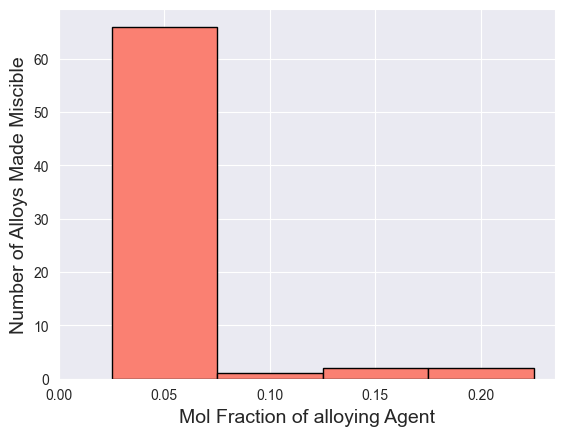

In [313]:
x_speed = np.linspace(0, 1, 5)
x_speed = x_speed/ (4+1)
print(x_speed*100)
plt.bar(x_speed[1:], counter.values(), width=0.05, color='salmon', edgecolor='black')
plt.xticks(x_speed)
plt.xlabel('Mol Fraction of alloying Agent', fontsize=14)
plt.ylabel('Number of Alloys Made Miscible', fontsize=14)

In [314]:
add_ele_list = np.array(add_ele_list)

In [315]:
len(add_ele_list)

71

In [316]:
constraint1 = reduction > -4000
constraint2 = add_ele_list == 'Nb'

add_ele_cond = add_ele_list[constraint1 & constraint2]
reduction_cond = reduction[constraint1 & constraint2]

In [317]:
print(reduction_cond)

[151.83333333 219.83333333  42.         510.5        343.66666667
 292.83333333 607.33333333]


In [318]:
h_alloy_list_cond = h_alloy_list[constraint1 & constraint2]
h_comp_list_cond = h_comp_list[constraint1 & constraint2]
temperature_list_cond = temperature_list[constraint1 & constraint2]


In [319]:
ele, counts = np.unique(add_ele_list, return_counts=True)

In [320]:
indices = np.argsort(counts)

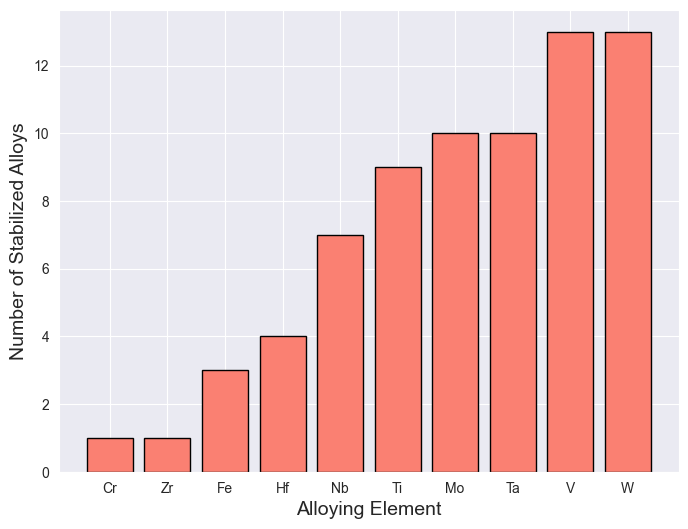

In [321]:
plt.figure(figsize=(8, 6))
plt.bar(ele[indices], counts[indices], color = 'salmon', edgecolor = 'black')
plt.xlabel('Alloying Element', fontsize=14)
plt.ylabel('Number of Stabilized Alloys', fontsize=14)
plt.show()

In [322]:
constraint = add_ele_list == 'Nb'


Text(0, 0.5, 'Change in Miscibility (K)')

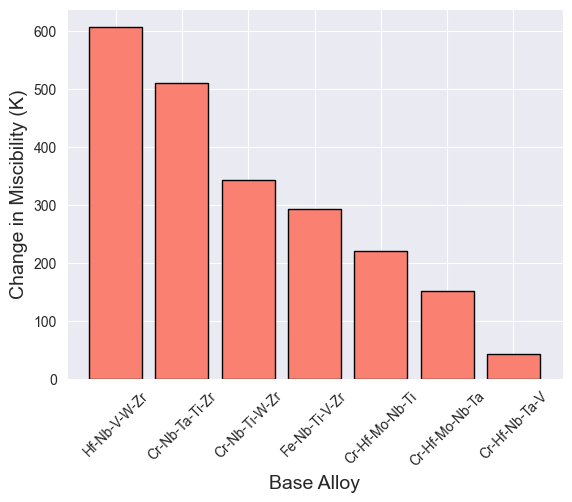

In [323]:
base_alloy_list = np.array(base_alloy_list)
base_alloy_list[constraint]
indexs = np.argsort(reduction[constraint])[::-1]
plt.bar(base_alloy_list[constraint][indexs], reduction[constraint][indexs], color = 'salmon', edgecolor = 'black')
plt.xticks(rotation = 45)
plt.xlabel('Base Alloy', fontsize=14)
plt.ylabel('Change in Miscibility (K)', fontsize=14)

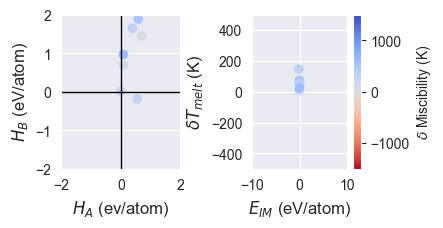

In [324]:
# four scatter plots for hc, ha, im, temp

fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].scatter(h_alloy_list[constraint], h_comp_list[constraint], c = reduction[constraint], cmap='coolwarm_r', vmin=-1500, vmax=1500)
ax[0].set_xlim(-2, 2)
ax[0].set_ylim(-2, 2)
sc = ax[1].scatter(im_formation_list[constraint], temperature_list[constraint], c = reduction[constraint], cmap='coolwarm_r', vmin=-1500, vmax=1500)
ax[0].axhline(0, color='black', lw=1)
ax[0].axvline(0, color='black', lw=1)
ax[0].set_xlabel('$H_A$ (ev/atom)', fontsize=12)
ax[0].set_ylabel('$H_B$ (eV/atom)', fontsize=12)
ax[1].set_xlabel('$E_{IM}$ (eV/atom)', fontsize=12)
ax[1].set_ylabel('$\delta T_{melt}$ (K)', fontsize=12)
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-500, 500)
plt.subplots_adjust(wspace=0.6)

fig.colorbar(sc, ax=ax[1], label='$\delta$ Miscibility (K)')

In [325]:
# plt.scatter(h_alloy_list, h_comp_list, c = add_ele_list)
# plt.colorbar()
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
# plt.xlabel('$H_A$ (ev/atom)', fontsize=14)
# plt.ylabel('$H_B$ (eV/atom)', fontsize=14)

In [326]:
n = np.linspace(2, 10)

delta_h = (1 - 2*(n+1))*h_comp_list + (n + 1 - 1)*n*h_alloy_list
delta_h *= (1/(n+1)*n)**2

ValueError: operands could not be broadcast together with shapes (50,) (71,) 

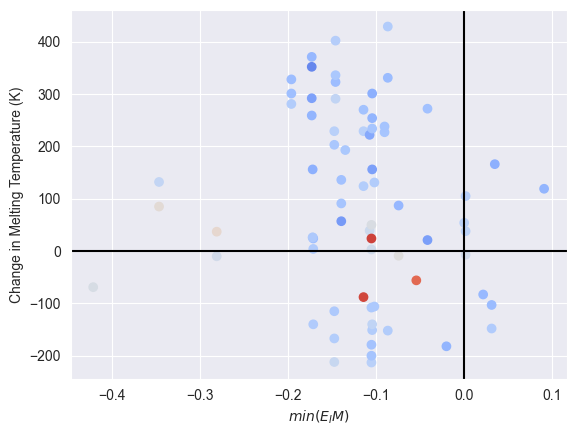

In [201]:
plt.scatter(im_formation_list, temperature_list, c = reduction, cmap='coolwarm_r', vmin=-1500, vmax=1500)
# plt.scatter(temperature_list, reduction, c = reduction, cmap='coolwarm_r', vmin=-1500, vmax=1500)
plt.axvline(0, c='black')
plt.axhline(0, c='black')
plt.xlabel('$min(E_IM)$')
plt.ylabel('Change in Melting Temperature (K)')
# plt.ylabel('Change in Miscibility (K)')
plt.show()

In [202]:
h_comp_cond = h_comp_list[delta_h <= 0]
h_alloy_cond = h_alloy_list[delta_h <= 0]
delta_h_cond = delta_h[delta_h <= 0]

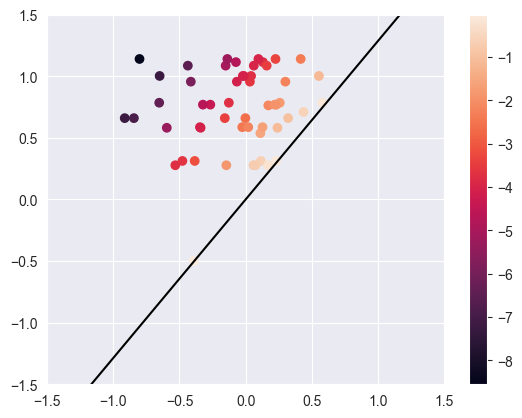

In [203]:
plt.scatter(h_alloy_cond, h_comp_cond, c = delta_h_cond)
plt.plot(np.linspace(-1.5, 1.5, 40), 9/7*np.linspace(-1.5, 1.5, 40), c='black')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.colorbar()

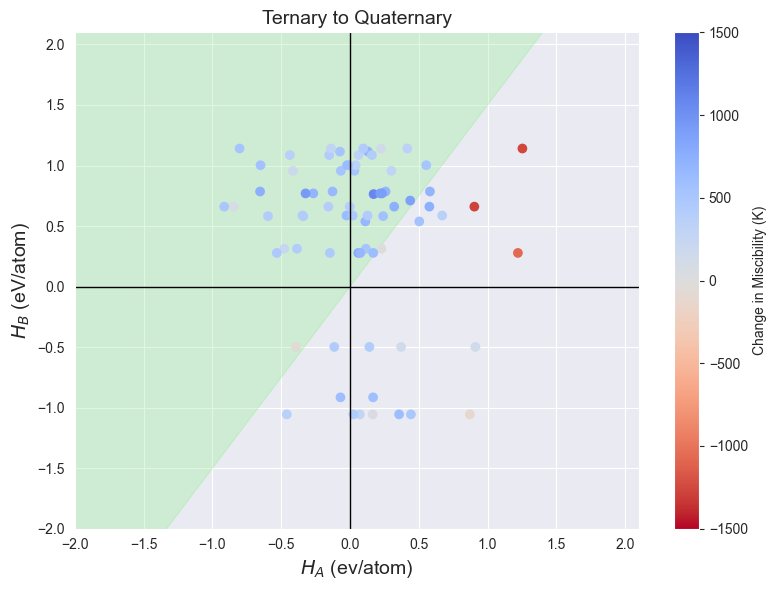

In [204]:
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot


x = np.linspace(-2, 2, 500)
y = np.linspace(-3, 3, 500)

# Second quadrant (Condition 1)
# ax.fill_betweenx(y, -2, 0, where=(y > 0), color='lightgreen', alpha=0.3, label='Condition 1: Second quadrant')

# First quadrant and third quadrant (Condition 2)
ax.fill_between(
    x, (3 / 2) * x, 3, color='lightgreen', alpha=0.3, label='abs(h_comp / h_alloy) > 3/2'
)

sc = ax.scatter(h_alloy_list, h_comp_list, c=reduction, cmap='coolwarm_r', zorder = 2, vmin = -1500, vmax = 1500)
ax.axhline(0, color='black', lw=1)
ax.axvline(0, color='black', lw=1)
plt.colorbar(sc, label='Change in Miscibility (K)')
# Labels and legend
ax.set_xlabel('$H_A$ (ev/atom)', fontsize=14)
ax.set_ylabel('$H_B$ (eV/atom)', fontsize=14)
ax.set_title('Ternary to Quaternary', fontsize=14)
# ax.legend(fontsize=10, loc='upper left')
ax.set_xlim(-2, 2.1)
ax.set_ylim(-2, 2.1)
plt.tight_layout()
plt.show()

In [205]:
condition1 = (h_comp_list >= 0) & (h_alloy_list <= 0)
condition2 = h_comp_list / h_alloy_list > (9/7) 
# Combined condition: Condition 1 or Condition 2
# combined_condition = condition1 | condition2
combined_condition = condition1 | condition2
num_points = np.sum(combined_condition)  # Count points satisfying the combined condition
print(f"Number of points satisfying the combined condition: {num_points}")

Number of points satisfying the combined condition: 55


In [206]:
reduction_cond = reduction[np.where(combined_condition==True)[0]]
delta_h_cond = delta_h[np.where(combined_condition==True)[0]]

In [207]:
delta_h_cond < 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [208]:
print(np.sum(reduction_cond > 0)/ len(reduction_cond))

0.9818181818181818
